# Pizza Sales! 🍕

Welcome to our Pizza Sales Challenge, here you’ll be playing the role of a Consultant hired by Plato's Pizza, a Greek-inspired pizza place in NYC, to help the restaurant use data to improve operations. You've received the following note:

> Welcome aboard, we're so glad you're here to help!
> Things are going OK here at Plato's, but there's room for improvement. We've been collecting transactional data for the past year, but really haven't been able to put it to good use. Hoping you can analyze the data and put together a report to help us find opportunities to drive more sales and work more efficiently.
>
> -Plato, CEO

Plato's Pizza has historically been using Excel for their sales reporting needs, but want to see if there could be a more effective, scalable solution. They want to be able to monitor key business metrics such as: 

* What days and times do we tend to be busiest?
* How many pizzas are we making during peak periods?
* What are our best and worst-selling pizzas?
* What's our average order value?

Let's use Atoti to analyze Plato's Pizza sales, and address their operational needs.

## Import Libraries

First off, let's import the necessary libraries.

In [1]:
import atoti
import pandas as pd

## Instantiate Atoti Server and UI

Now, we'll spin up the Atoti server and link the session to our web-based Atoti UI.

**💡 Note:**  https://docs.atoti.io/latest/api/atoti.Session.html#atoti.Session

In [2]:
# Start an Atoti Server instance
session = atoti.Session(
    user_content_storage="./content",
    port=9092,
    java_options=["-Xms1G", "-Xmx10G"],
)
session.link

http://localhost:9092

_Note_: This is the session's local URL: it may not be reachable if Atoti is running on another machine.

## Inspect Data Quality Using Pandas

Next, let's load up Pandas to quickly take a look at the pizza sales data, inspect it's quality, and make quick formatting changes if need be.

In [3]:
# Read CSV into Pandas DataFrame
pizza_sales_df = pd.read_csv("s3://data.atoti.io/notebooks/pizza-sales/pizza_sales.csv")
pizza_sales_df.head()

,order_details_id,order_id,pizza_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name
0,1,1,hawaiian_m,1,1/1/15,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza
1,2,2,classic_dlx_m,1,1/1/15,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza
2,3,2,five_cheese_l,1,1/1/15,11:57:40,18.50,18.50,L,Veggie,"Mozzarella Cheese, Provolone Cheese, Smoked Go...",The Five Cheese Pizza
3,4,2,ital_supr_l,1,1/1/15,11:57:40,20.75,20.75,L,Supreme,"Calabrese Salami, Capocollo, Tomatoes, Red Oni...",The Italian Supreme Pizza
4,5,2,mexicana_m,1,1/1/15,11:57:40,16.00,16.00,M,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza


Nice, looks like we're working with some pretty intact data.

In [4]:
# Check null counts for each column
pizza_sales_df.isnull().sum(axis=0)

order_details_id     0
order_id             0
pizza_id             0
quantity             0
order_date           0
order_time           0
unit_price           0
total_price          0
pizza_size           0
pizza_category       0
pizza_ingredients    0
pizza_name           0
dtype: int64

Let's take a look at the data types of our columns.

In [5]:
# Check column data types
pizza_sales_df.dtypes

order_details_id       int64
order_id               int64
pizza_id              object
quantity               int64
order_date            object
order_time            object
unit_price           float64
total_price          float64
pizza_size            object
pizza_category        object
pizza_ingredients     object
pizza_name            object
dtype: object

## Format Data in Pandas

Upon inspection, it looks like a few things need to be updated:

* Our `order_date` column needs to be set to a DateTime data type.
* We need to create a `dayofweek` column/attribute to answer best/worst sales on week days.
* Intended hierarchies set as numerical data types should be set as strings for Atoti (e.g. no need to aggregate order ids!)

**💡 Note:**  https://docs.atoti.io/latest/getting_started/tutorial/tutorial.html#Multidimensional-concepts

In [6]:
# Convert string to datetime and set day of the week (e.g. Monday=0, Sunday=6)
pizza_sales_df["order_datetime"] = pd.to_datetime(
    pizza_sales_df["order_date"] + " " + pizza_sales_df["order_time"], format="mixed"
)
# pizza_sales_df["order_date"] = pd.to_datetime(
#     pizza_sales_df["order_date"], format="mixed"
# )
pizza_sales_df["dayofweek"] = pizza_sales_df["order_datetime"].dt.day_name()

# Cast as string data types and view modified DataFrame
pizza_sales_df["order_details_id"] = pizza_sales_df["order_details_id"].astype(str)
pizza_sales_df["order_id"] = pizza_sales_df["order_id"].astype(str)
pizza_sales_df["dayofweek"] = pizza_sales_df["dayofweek"].astype(str)
pizza_sales_df.head()

,order_details_id,order_id,pizza_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name,order_datetime,dayofweek
0,1,1,hawaiian_m,1,1/1/15,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,2015-01-01 11:38:36,Thursday
1,2,2,classic_dlx_m,1,1/1/15,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza,2015-01-01 11:57:40,Thursday
2,3,2,five_cheese_l,1,1/1/15,11:57:40,18.50,18.50,L,Veggie,"Mozzarella Cheese, Provolone Cheese, Smoked Go...",The Five Cheese Pizza,2015-01-01 11:57:40,Thursday
3,4,2,ital_supr_l,1,1/1/15,11:57:40,20.75,20.75,L,Supreme,"Calabrese Salami, Capocollo, Tomatoes, Red Oni...",The Italian Supreme Pizza,2015-01-01 11:57:40,Thursday
4,5,2,mexicana_m,1,1/1/15,11:57:40,16.00,16.00,M,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza,2015-01-01 11:57:40,Thursday


In [7]:
pizza_sales_df

,order_details_id,order_id,pizza_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name,order_datetime,dayofweek
0,1,1,hawaiian_m,1,1/1/15,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,2015-01-01 11:38:36,Thursday
1,2,2,classic_dlx_m,1,1/1/15,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza,2015-01-01 11:57:40,Thursday
2,3,2,five_cheese_l,1,1/1/15,11:57:40,18.50,18.50,L,Veggie,"Mozzarella Cheese, Provolone Cheese, Smoked Go...",The Five Cheese Pizza,2015-01-01 11:57:40,Thursday
3,4,2,ital_supr_l,1,1/1/15,11:57:40,20.75,20.75,L,Supreme,"Calabrese Salami, Capocollo, Tomatoes, Red Oni...",The Italian Supreme Pizza,2015-01-01 11:57:40,Thursday
4,5,2,mexicana_m,1,1/1/15,11:57:40,16.00,16.00,M,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza,2015-01-01 11:57:40,Thursday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48615,48616,21348,ckn_alfredo_m,1,12/31/15,21:23:10,16.75,16.75,M,Chicken,"Chicken, Red Onions, Red Peppers, Mushrooms, A...",The Chicken Alfredo Pizza,2015-12-31 21:23:10,Thursday
48616,48617,21348,four_cheese_l,1,12/31/15,21:23:10,17.95,17.95,L,Veggie,"Ricotta Cheese, Gorgonzola Piccante Cheese, Mo...",The Four Cheese Pizza,2015-12-31 21:23:10,Thursday
48617,48618,21348,napolitana_s,1,12/31/15,21:23:10,12.00,12.00,S,Classic,"Tomatoes, Anchovies, Green Olives, Red Onions,...",The Napolitana Pizza,2015-12-31 21:23:10,Thursday
48618,48619,21349,mexicana_l,1,12/31/15,22:09:54,20.25,20.25,L,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza,2015-12-31 22:09:54,Thursday


Lastly, let's take a look at our column data types again to verify our data formatting. Great, looks like our changes went through!

In [8]:
# Check new column data types
pizza_sales_df.dtypes

order_details_id             object
order_id                     object
pizza_id                     object
quantity                      int64
order_date                   object
order_time                   object
unit_price                  float64
total_price                 float64
pizza_size                   object
pizza_category               object
pizza_ingredients            object
pizza_name                   object
order_datetime       datetime64[ns]
dayofweek                    object
dtype: object

## Load Pandas DataFrame Into Atoti Cube

Now, let's load our formatted data from our Pandas DataFrame to an Atoti table using the `read_pandas()` function, verify that the data was loaded properly, and create our Atoti cube.

**💡 Note:**  https://docs.atoti.io/latest/api/atoti.Session.read_pandas.html#atoti.Session.read_pandas

In [9]:
# Load Pandas DataFrame as Atoti Table object
pizza_sales_table = session.read_pandas(
    pizza_sales_df, table_name="pizza_sales_table", keys=["order_details_id"]
)
pizza_sales_table.head()

,order_id,pizza_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name,order_datetime,dayofweek
order_details_id,,,,,,,,,,,,,
13,7,spinach_supr_s,1,1/1/15,12:50:37,12.5,12.5,S,Supreme,"Spinach, Red Onions, Pepperoni, Tomatoes, Arti...",The Spinach Supreme Pizza,2015-01-01 12:50:37,Thursday
27,11,cali_ckn_l,1,1/1/15,13:02:59,20.75,20.75,L,Chicken,"Chicken, Artichoke, Spinach, Garlic, Jalapeno ...",The California Chicken Pizza,2015-01-01 13:02:59,Thursday
41,16,napolitana_s,1,1/1/15,13:34:07,12.0,12.0,S,Classic,"Tomatoes, Anchovies, Green Olives, Red Onions,...",The Napolitana Pizza,2015-01-01 13:34:07,Thursday
55,19,sicilian_l,1,1/1/15,13:59:09,20.25,20.25,L,Supreme,"Coarse Sicilian Salami, Tomatoes, Green Olives...",The Sicilian Pizza,2015-01-01 13:59:09,Thursday
69,26,classic_dlx_s,1,1/1/15,14:54:26,12.0,12.0,S,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza,2015-01-01 14:54:26,Thursday


**💡 Note:**  https://docs.atoti.io/latest/api/atoti.Session.create_cube.html#atoti.Session.create_cube

In [10]:
# Create Cube from Atoti Table object
cube = session.create_cube(pizza_sales_table)

## Cube Data Model Analysis

Now, let's verify the cube has been set up properly, and take a look at the schema of the cube, along with the hierarchies, levels, and measures automatically created.

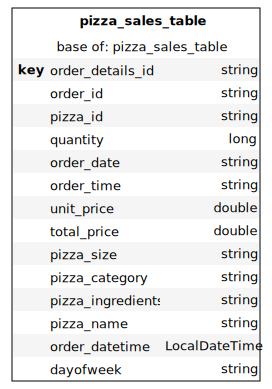

In [11]:
# View the schema
session.tables.schema

In [12]:
# Set variables for hierarchies, levels, and measures
h, l, m = cube.hierarchies, cube.levels, cube.measures

## Adding a Multi-Level Hierarchy

Oftentimes for dates and datetime columns, we'll want to create a multi-level date hierarchy so that measure aggregations and corresponding date bucketization can be done on the fly.


In [13]:
# Create a multi-level date hierarchy
cube.create_date_hierarchy(
    "multi-level date",
    column=pizza_sales_table["order_datetime"],
    levels={
        "Year": "yyyy",
        "Quarter": "QQQ",
        "Month": "MMM",
        "Day": "dd",
        "Hour": "HH",
    },
)
h

{('pizza_sales_table', 'dayofweek'): <atoti.hierarchy.Hierarchy object at 0x17faba0e0>, ('pizza_sales_table', 'pizza_id'): <atoti.hierarchy.Hierarchy object at 0x17faba140>, ('pizza_sales_table', 'pizza_name'): <atoti.hierarchy.Hierarchy object at 0x17faba230>, ('pizza_sales_table', 'order_datetime'): <atoti.hierarchy.Hierarchy object at 0x17faba320>, ('pizza_sales_table', 'pizza_ingredients'): <atoti.hierarchy.Hierarchy object at 0x17faba410>, ('pizza_sales_table', 'multi-level date'): <atoti.hierarchy.Hierarchy object at 0x17faba500>, ('pizza_sales_table', 'order_id'): <atoti.hierarchy.Hierarchy object at 0x17faba5f0>, ('pizza_sales_table', 'order_date'): <atoti.hierarchy.Hierarchy object at 0x17faba9e0>, ('pizza_sales_table', 'order_details_id'): <atoti.hierarchy.Hierarchy object at 0x17fabaad0>, ('pizza_sales_table', 'pizza_category'): <atoti.hierarchy.Hierarchy object at 0x17fababc0>, ('pizza_sales_table', 'order_time'): <atoti.hierarchy.Hierarchy object at 0x17fabacb0>, ('pizza_sales_table', 'pizza_size'): <atoti.hierarchy.Hierarchy object at 0x17fabada0>}

In [14]:
# View levels for the cube
l

In [15]:
# View measures for the cube
m

{'contributors.COUNT': <atoti.measure.Measure object at 0x1733dba30>, 'update.TIMESTAMP': <atoti.measure.Measure object at 0x17fae92d0>, 'unit_price.MEAN': <atoti.measure.Measure object at 0x17faea050>, 'unit_price.SUM': <atoti.measure.Measure object at 0x17faea020>, 'quantity.MEAN': <atoti.measure.Measure object at 0x17fae9000>, 'quantity.SUM': <atoti.measure.Measure object at 0x17fae9120>, 'total_price.MEAN': <atoti.measure.Measure object at 0x17fae9270>, 'total_price.SUM': <atoti.measure.Measure object at 0x17fae9f90>}

In [16]:
# * How many pizzas are we making during peak periods?
# * What are our best and worst-selling pizzas?
# * What's our average order value?

## Data Analysis and Visualization in Atoti

With the data in the cube ready-to-go, let's now get to slicing-and-dicing! Be aware that from this point onwards we'll be using the Atoti JupyterLab extension which allows us to create notebook widgets and interact with Atoti and the data in the cube. Select the Atoti JupyterLab extension in your left-hand menu pane to follow along. Otherwise, you can always go to [http://localhost:9092/#/dashboard/e49](http://localhost:9092/#/dashboard/e49) to pull up the dashboard.

 

### What days and times do we tend to be busiest?



Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
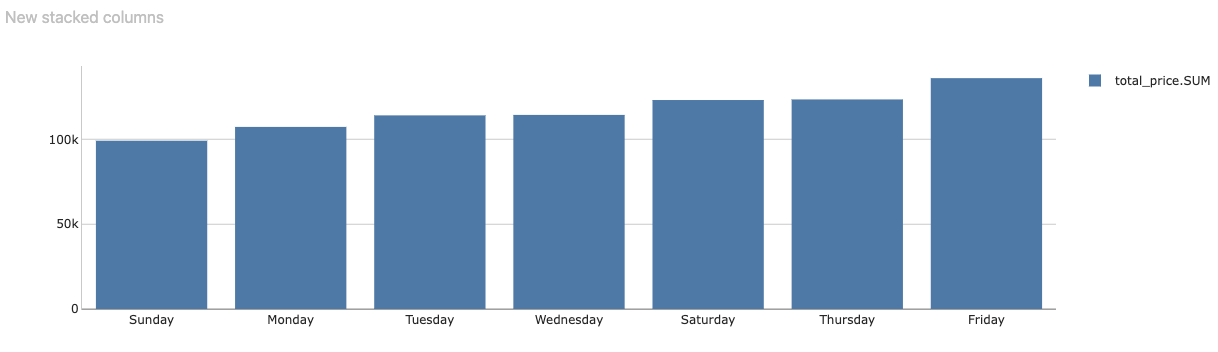

In [17]:
session.widget

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
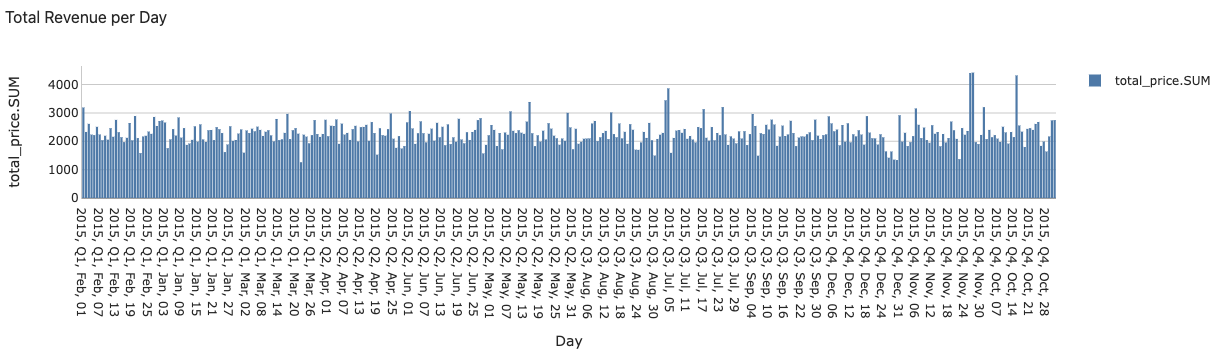

In [18]:
# Set x-axis as order_date, y-axis as total_price.SUM
session.widget

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
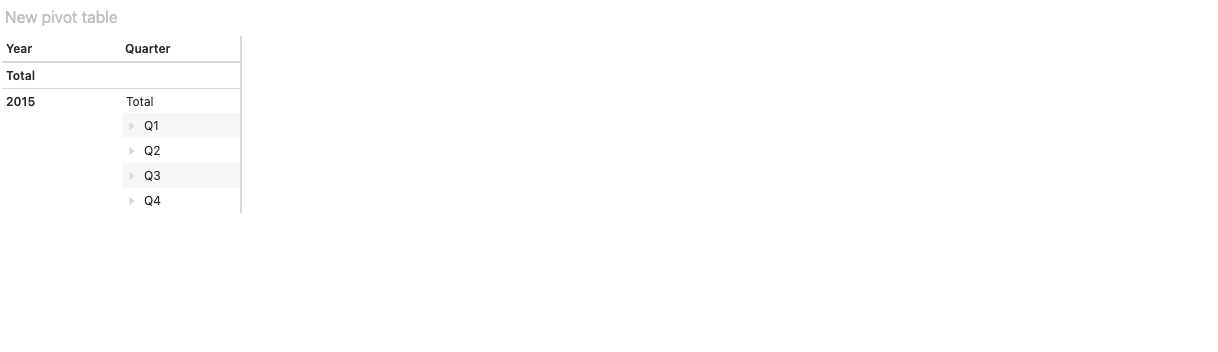

In [19]:
# Set x-axis as multi-level date hierarchy, y-axis as total_price.SUM
session.widget

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
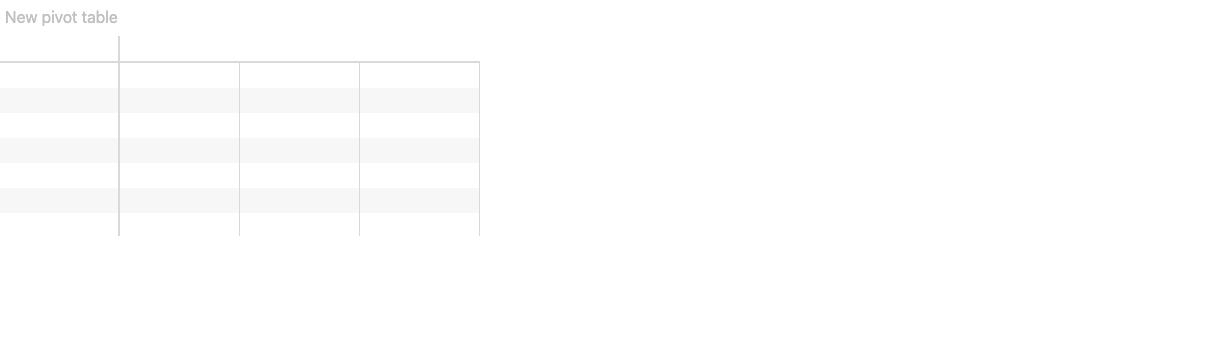

In [20]:
# Calculate correct average monthly quantity and mean, wrt to month level
m["AVG Monthly Quantity"] = atoti.agg.mean(
    m["quantity.SUM"], scope=atoti.OriginScope(l["Month"])
)
m["AVG Monthly Revenue"] = atoti.agg.mean(
    m["total_price.SUM"], scope=atoti.OriginScope(l["Month"])
)
session.widget

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
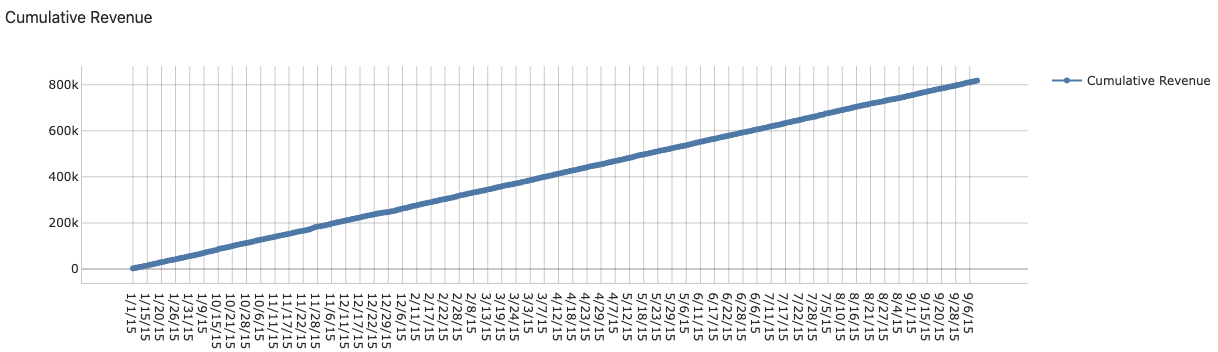

In [21]:
# Calculate cumulative daily revenue
m["Cumulative Revenue"] = atoti.agg.sum(
    m["total_price.SUM"], scope=atoti.CumulativeScope(level=l["order_date"])
)
session.widget

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
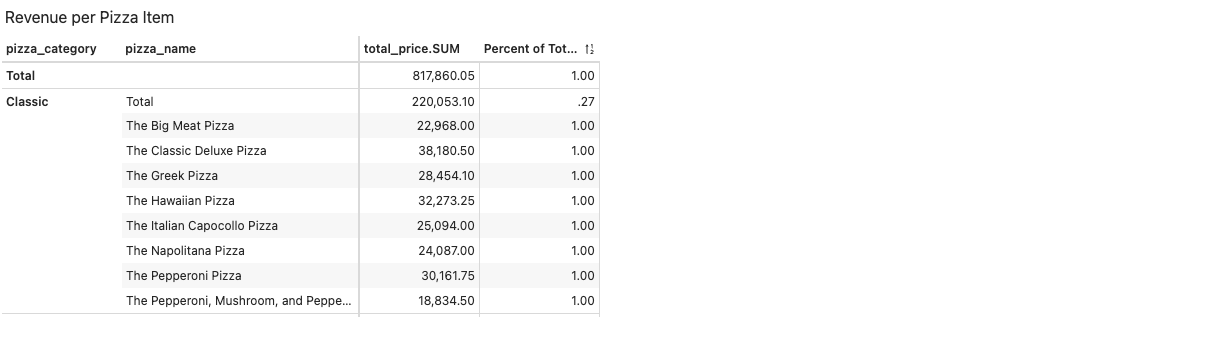

In [22]:
# Calculate percent of total revenue by pizza item (incorrect)
m["Percent of Total Revenue"] = m["total_price.SUM"] / atoti.total(
    m["total_price.SUM"], h["pizza_category"]
)
session.widget

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
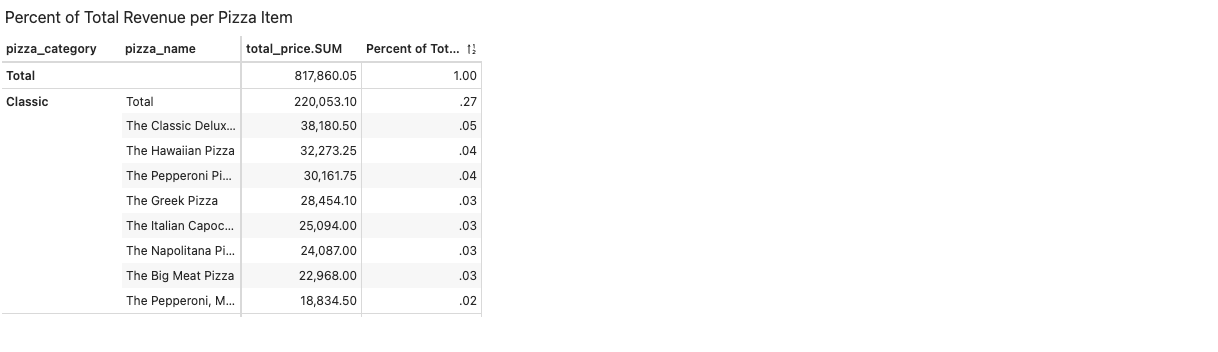

In [23]:
# Calculate percent of total revenue by pizza item (correct)
m["Percent of Total Revenue"] = m["total_price.SUM"] / atoti.total(
    m["total_price.SUM"], h["pizza_category"], h["pizza_name"]
)
session.widget

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
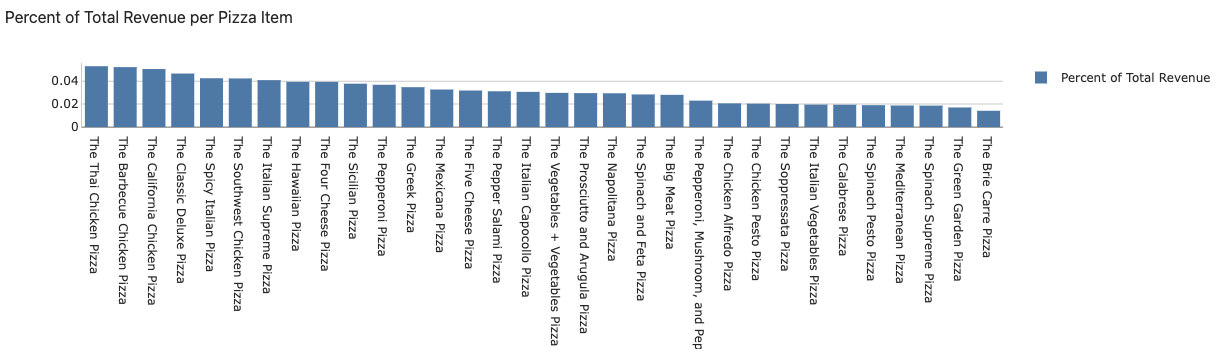

In [24]:
# Visualize percent of total revenue by pizza item
session.widget

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
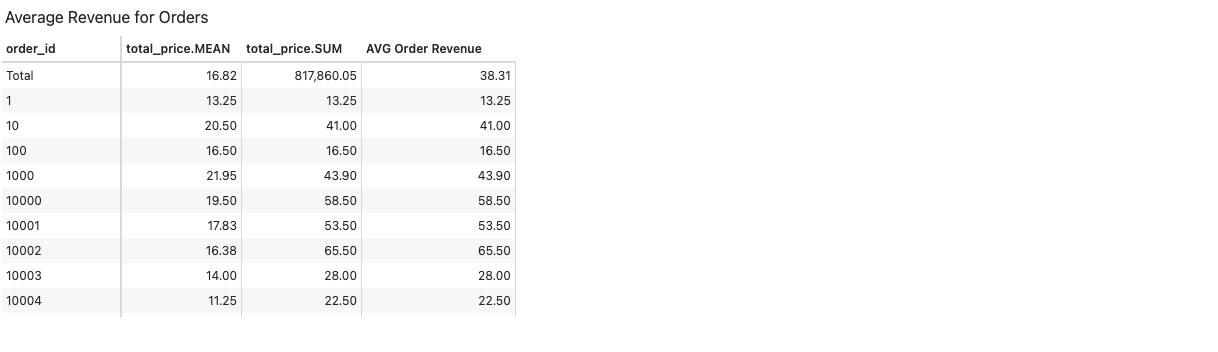

In [25]:
# Calculate average revenue per order
m["AVG Order Revenue"] = atoti.agg.mean(
    m["total_price.SUM"], scope=atoti.OriginScope(l["order_id"])
)
session.widget